
# Semana 9 — Técnicas de Otimização: Dropout & BatchNorm 🧠⚙️

Neste notebook você vai:
1) Treinar um **MLP baseline** (sem otimizações) no `make_moons`.  
2) Treinar um **MLP com Dropout + BatchNorm**.  
3) Comparar **curvas de loss**, **acurácia** e **fronteiras de decisão**.  
4) Entender quando usar cada técnica e o impacto prático na **generalização**.

> Requisitos: `torch`, `scikit-learn`, `matplotlib`.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) Dados: `make_moons` + padronização

In [2]:

X, y = make_moons(n_samples=2000, noise=0.25, random_state=SEED)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

Xtr_t = torch.tensor(X_tr_s, dtype=torch.float32)
ytr_t = torch.tensor(y_tr,   dtype=torch.long)
Xte_t = torch.tensor(X_te_s, dtype=torch.float32)
yte_t = torch.tensor(y_te,   dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte_t, yte_t),  batch_size=256, shuffle=False)

X_tr_s.shape, X_te_s.shape


((1500, 2), (500, 2))

## 2) Modelos: baseline vs otimizado

In [3]:

class MLPPlain(nn.Module):
    def __init__(self, in_dim=2, hidden=(32,16), out_dim=2):
        super().__init__()
        h1, h2 = hidden
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MLPOptimized(nn.Module):
    def __init__(self, in_dim=2, hidden=(32,16), out_dim=2, p=0.3):
        super().__init__()
        h1, h2 = hidden
        self.fc1 = nn.Linear(in_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.do1 = nn.Dropout(p)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.do2 = nn.Dropout(p)
        self.fc3 = nn.Linear(h2, out_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.do2(x)
        x = self.fc3(x)
        return x


## 3) Funções de treino/avaliação

In [5]:

def train_model(model, train_loader, test_loader, epochs=200, lr=1e-3, wd=1e-4, device=device):
    model = model.to(device)
    crit = nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    tr_losses, va_losses = [], []
    for ep in range(1, epochs+1):
        model.train()
        run = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            run += loss.item() * xb.size(0)
        tr_loss = run / len(train_loader.dataset)

        model.eval(); vrun = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                vrun += crit(model(xb), yb).item() * xb.size(0)
        va_loss = vrun / len(test_loader.dataset)

        tr_losses.append(tr_loss); va_losses.append(va_loss)
        if ep % 25 == 0 or ep == 1:
            print(f"epoch {ep:03d} | train={tr_loss:.4f} | val={va_loss:.4f}")
    return model, tr_losses, va_losses

def accuracy(model, loader):
    model.eval(); correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total   += yb.size(0)
    return correct / total


## 4) Treinar os dois modelos

In [6]:

epochs = 200

plain = MLPPlain()
optm  = MLPOptimized(p=0.3)

plain, plain_tr, plain_va = train_model(plain, train_loader, test_loader, epochs=epochs, lr=1e-3, wd=0.0)
optm,  optm_tr,  optm_va  = train_model(optm,  train_loader, test_loader, epochs=epochs, lr=1e-3, wd=1e-4)

acc_plain_tr = accuracy(plain, train_loader)
acc_plain_te = accuracy(plain, test_loader)
acc_optm_tr  = accuracy(optm,  train_loader)
acc_optm_te  = accuracy(optm,  test_loader)

print("\nAcurácias:")
print(f"Baseline — treino: {acc_plain_tr:.3f} | teste: {acc_plain_te:.3f}")
print(f"Dropout+BN — treino: {acc_optm_tr:.3f} | teste: {acc_optm_te:.3f}")


epoch 001 | train=0.6192 | val=0.5473
epoch 025 | train=0.1447 | val=0.1598
epoch 050 | train=0.1332 | val=0.1587
epoch 075 | train=0.1339 | val=0.1604
epoch 100 | train=0.1313 | val=0.1602
epoch 125 | train=0.1305 | val=0.1604
epoch 150 | train=0.1310 | val=0.1605
epoch 175 | train=0.1306 | val=0.1615
epoch 200 | train=0.1302 | val=0.1613
epoch 001 | train=0.6142 | val=0.4981
epoch 025 | train=0.2523 | val=0.1820
epoch 050 | train=0.2291 | val=0.1660
epoch 075 | train=0.2081 | val=0.1615
epoch 100 | train=0.2187 | val=0.1608
epoch 125 | train=0.2018 | val=0.1624
epoch 150 | train=0.2077 | val=0.1611
epoch 175 | train=0.1958 | val=0.1623
epoch 200 | train=0.1974 | val=0.1615

Acurácias:
Baseline — treino: 0.953 | teste: 0.932
Dropout+BN — treino: 0.953 | teste: 0.932


## 5) Curvas de loss

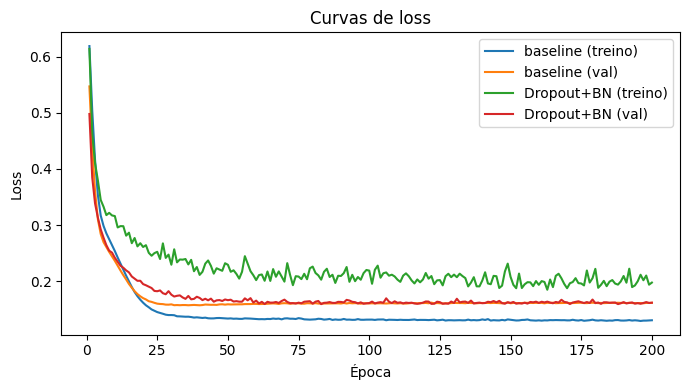

In [7]:

plt.figure(figsize=(7,4))
plt.plot(range(1, len(plain_tr)+1), plain_tr, label="baseline (treino)")
plt.plot(range(1, len(plain_va)+1), plain_va, label="baseline (val)")
plt.plot(range(1, len(optm_tr)+1),  optm_tr,  label="Dropout+BN (treino)")
plt.plot(range(1, len(optm_va)+1),  optm_va,  label="Dropout+BN (val)")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curvas de loss")
plt.legend(); plt.tight_layout(); plt.show()


## 6) Fronteiras de decisão (comparativo)

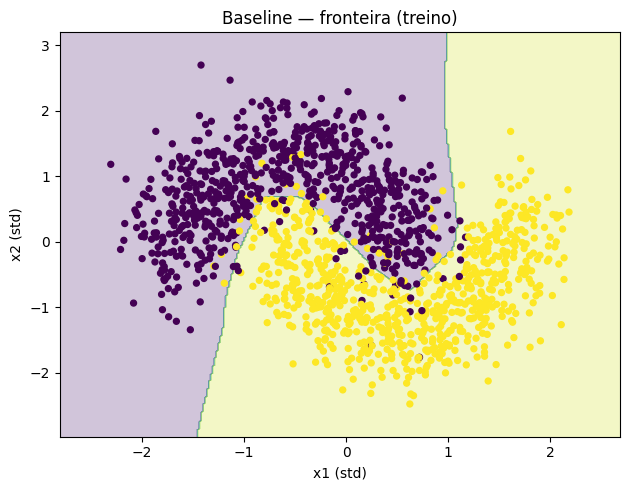

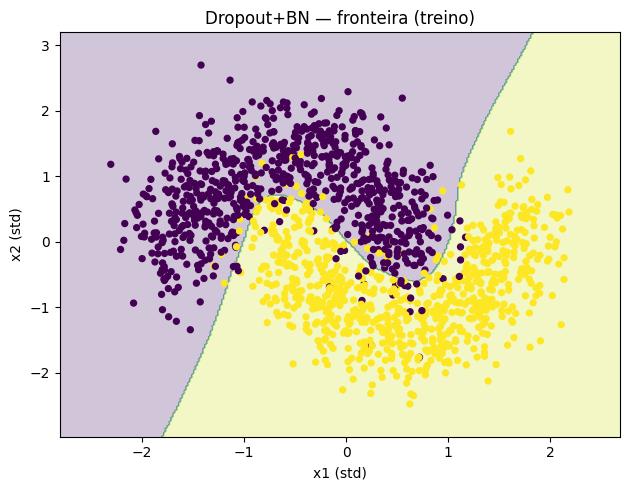

In [8]:

def plot_boundary(model, X, y, title=""):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    with torch.no_grad():
        Z = model(torch.tensor(grid, device=device)).argmax(1).view(xx.shape).cpu().numpy()
    plt.figure(figsize=(6.4,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=18)
    plt.title(title); plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.tight_layout(); plt.show()

plot_boundary(plain, X_tr_s, y_tr, "Baseline — fronteira (treino)")
plot_boundary(optm,  X_tr_s, y_tr, "Dropout+BN — fronteira (treino)")


## 7) Comparativo de métricas

In [9]:

df_cmp = pd.DataFrame({
    "modelo": ["baseline", "dropout+bn"],
    "acc_treino": [acc_plain_tr, acc_optm_tr],
    "acc_teste":  [acc_plain_te, acc_optm_te],
    "gap_(treino-teste)": [acc_plain_tr-acc_plain_te, acc_optm_tr-acc_optm_te]
})
df_cmp.sort_values("acc_teste", ascending=False)


,modelo,acc_treino,acc_teste,gap_(treino-teste)
0,baseline,0.953333,0.932,0.021333
1,dropout+bn,0.952667,0.932,0.020667



## 8) Observações práticas
- **Dropout** tende a **reduzir acc de treino** e **aumentar acc de teste** (menos overfitting).  
- **BatchNorm** costuma **acelerar convergência** e permitir **LR maior**.  
- Em CNNs modernas, **BatchNorm** é quase onipresente; **Dropout** é usado com parcimônia.  
- Em MLPs/tabulares, **Dropout** ajuda bastante; BatchNorm pode ou não ajudar (depende da distribuição).

### Parametrizações para brincar
- `p` no Dropout: 0.1 → 0.5  
- `hidden`: (64,32), (128,64)  
- `weight_decay` (L2): 0 → 1e-3  
- `lr`: 5e-4 → 2e-3  
- `epochs`: 100 → 400  
